# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [2]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

2025-10-27 14:48:37.382781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-27 14:48:38.193724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 14:48:40.276777: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/.",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128)
)

Found 13901 files belonging to 6 classes.


E0000 00:00:1761572927.089151   10495 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1761572927.097343   10495 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Exploring the data

In [5]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 128, 128, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: cardboard
   1: glass
   2: metal
   3: paper
   4: plastic
   5: trash


2025-10-27 11:22:20.267336: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


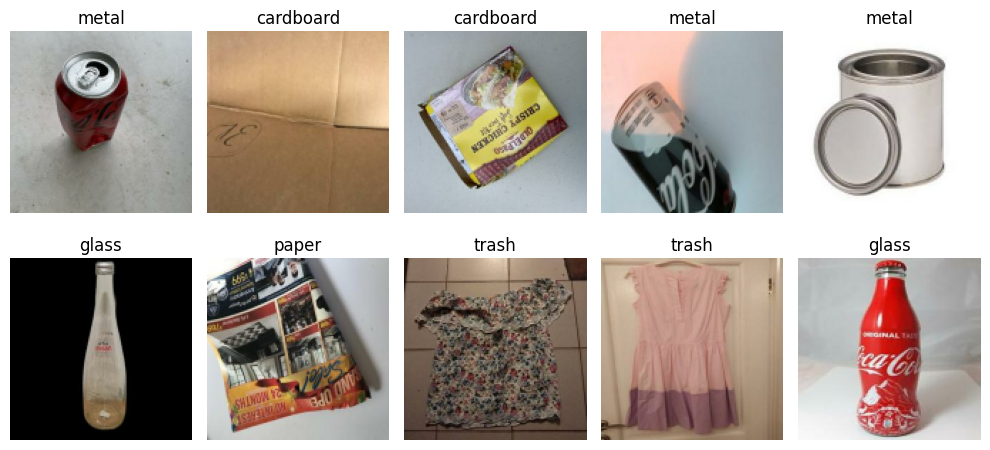

In [7]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets
- Normalizing the data

In [6]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/.",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Using 2780 files for validation.


2025-10-27 14:48:55.589918: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


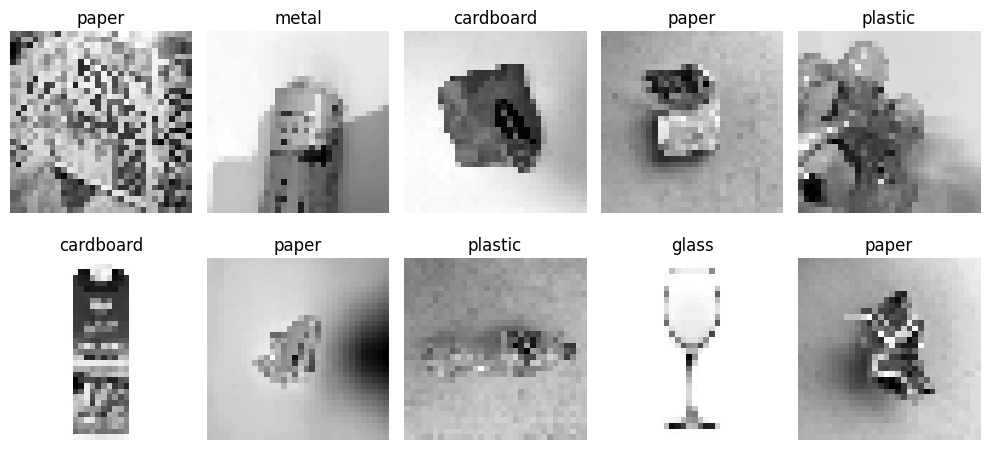

In [7]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

In [8]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


## Training the model

In [13]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (4, 4), activation="mish", input_shape=(32, 32, 1)
        ),
        tf.keras.layers.Conv2D(64, (2, 2), activation="mish"),
        tf.keras.layers.MaxPooling2D((3, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="mish"),
        tf.keras.layers.Dense(6),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,030 (1.30 MB)

 Trainable params: 341,030 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - loss: 1.7163 - sparse_categorical_accuracy: 0.2734 - val_loss: 1.6591 - val_sparse_categorical_accuracy: 0.3155
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 1.6281 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.6050 - val_sparse_categorical_accuracy: 0.3547
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 1.5821 - sparse_categorical_accuracy: 0.3624 - val_loss: 1.5657 - val_sparse_categorical_accuracy: 0.3824
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.3901 - val_loss: 1.5246 - val_sparse_categorical_accuracy: 0.4011
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 1.4989 - sparse_categorical_accuracy: 0.4202 - val_loss: 1.5116 - val_sparse_categorical_accuracy: 0.4032
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 1.4677 - sparse_categorical_accuracy: 0.4327 - val_loss: 1.4867 - val_sparse_categorical_accuracy:

## Model Evaluation

Evaluate the model on the validation set.

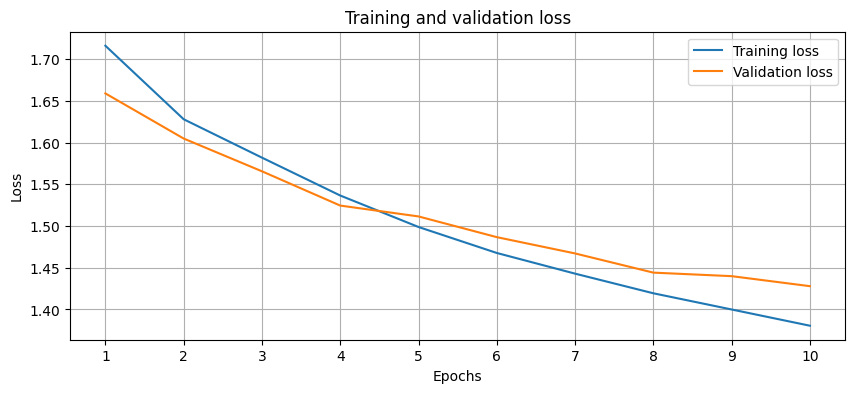

In [15]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.4279 - sparse_categorical_accuracy: 0.4471
Validation loss: 1.43
Validation accuracy: 44.71%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


2025-10-27 14:54:55.555244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


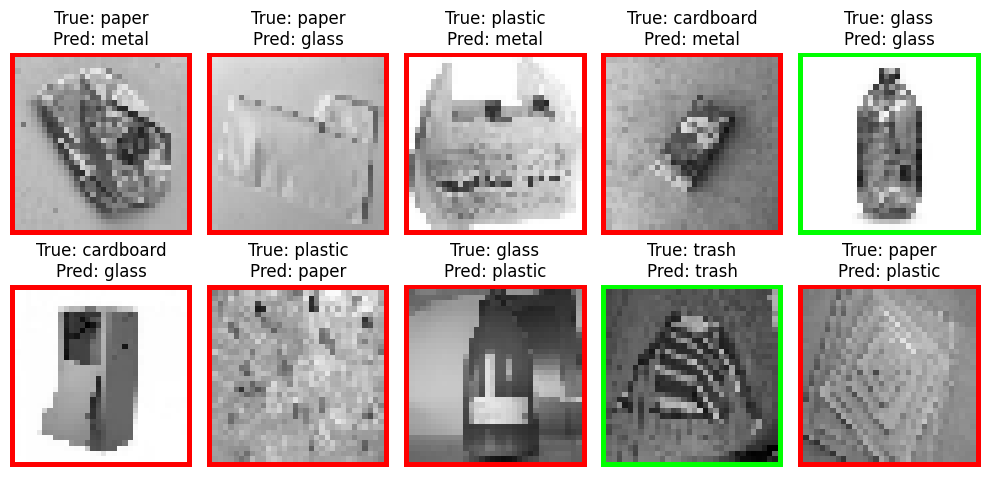

In [17]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


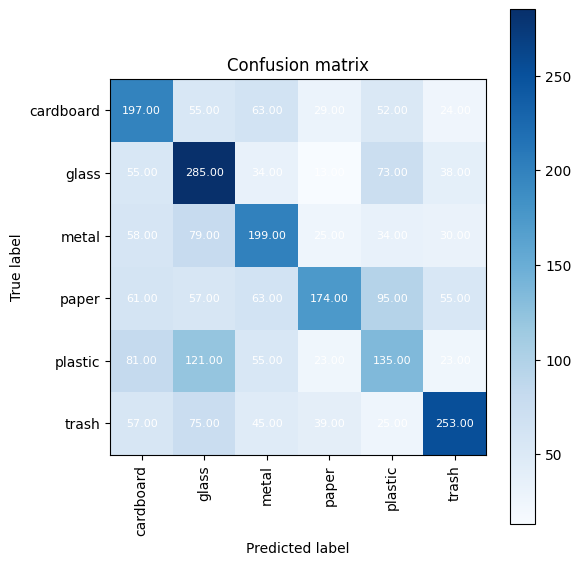

In [18]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()